In [1]:
from transformers import BridgeTowerModel, BridgeTowerProcessor
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from PIL import Image
import os

c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 3: Feature Alignment
We will use the FLickr30K dataset to estimate the linear transformation matrices that explicitly align the BridgeTower feature space

In [2]:
from datasets import load_dataset

dataset = load_dataset("nlphuji/flickr30k")

c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [3]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})

In [4]:
test_dataset = dataset['test']

In [5]:
test_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg'}

Two young guys with shaggy hair look at their hands while hanging out in the yard. Two young, White males are outside near many bushes. Two men in green shirts are standing in a yard. A man in a blue shirt standing in a garden. Two friends enjoy time spent together.


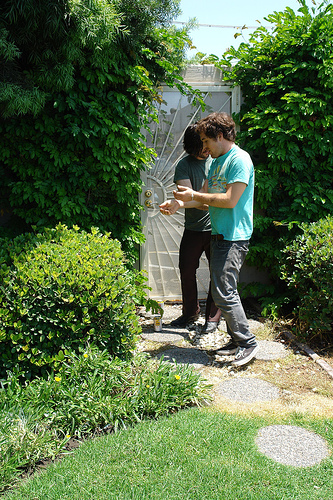

In [6]:
print(" ".join(test_dataset[0]['caption']))
test_dataset[0]['image']

### 1 Extract features

In [8]:
# Set up model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}

def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.cross_modal_image_pooler.register_forward_hook(
    get_features('layer_8'))

processor = BridgeTowerProcessor.from_pretrained(
    "BridgeTower/bridgetower-base")

In [9]:
len(test_dataset)

31014

In [10]:
# Go through each photo
data = []
for item in range(len(test_dataset)):
    image = test_dataset[item]['image']
    image_array = np.array(image)
    caption = " ".join(test_dataset[item]['caption'])

    # Run image
    image_input = processor(image_array, "", return_tensors="pt")
    _ = model(**image_input)

    image_vector = features['layer_8']


    # Run caption
    # Create a numpy array filled with gray values (128 in this case)
    # THis will act as tthe zero image input***
    gray_value = 128
    gray_image_array = np.full((512, 512, 3), gray_value, dtype=np.uint8)

    caption_input = processor(gray_image_array, caption,
                                return_tensors="pt")
    _ = model(**caption_input)

    caption_vector = features['layer_8']

    data.append([image_vector, caption_vector])

    np.save("results/feature_alignment/alignment_data.npy", data)


### 2 Predict features

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

#### Predict each visual feature from language feature (caption --> image)

In [16]:
data = np.load("results/feature_alignment/alignment_data.npy", allow_pickle=True)

In [17]:
data.shape

(31014, 2, 768)

In [18]:
image_to_caption_matrices = np.zeros((768, 768))
caption_to_image_matrices = np.zeros((768, 768))

In [21]:
alphas = np.logspace(-6, 6, 50) # Range for alphas

for i in range(768):  # Iterate over each feature in the target space
    ridge_cv = RidgeCV(alphas=alphas)

    # For image to caption
    target_feature = data[:, 1, i]  # i-th feature of all captions
    source_features = data[:, 0, :]  # All features of images
    ridge_cv.fit(source_features, target_feature)
    image_to_caption_matrices[i, :] = ridge_cv.coef_
    np.save("results\\feature_alignment\\image_to_caption_matrices.npy", image_to_caption_matrices)


    # For caption to image
    target_feature = data[:, 0, i]  # i-th feature of all images
    source_features = data[:, 1, :]  # All features of captions
    ridge_cv.fit(source_features, target_feature)
    caption_to_image_matrices[i, :] = ridge_cv.coef_
    np.save("results\\feature_alignment\\caption_to_image_matrices.npy", caption_to_image_matrices)